In [128]:
import numpy as np
import nengo

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [178]:
def generate_vocab(k, d, a, b, rng=np.random):
    sphere = nengo.dists.UniformHypersphere(surface=True)
    center = a * sphere.sample(1, d, rng=rng)
    preturb = b * rng.randn(k, d)
    vocab = center + preturb
    vocab /= np.linalg.norm(vocab, axis=1)[:, None]
    return vocab, np.linalg.norm(np.mean(vocab, axis=0))

def go(n=1000, p=0.1, k=100, d=64, presentation_time=0.1, dt=0.001,
       tau_adapt=100, inc_n=1.0, rng=np.random):
    # magic constants hand-picked to give:
    # simi1 ~= 0.64 and simi2 ~= 0.32, when k == 100 and d == 64
    M1, simi1 = generate_vocab(k, d, 0.8, 0.12, rng=rng)
    M2, simi2 = generate_vocab(k, d, 0.5, 0.20, rng=rng)
    print(simi1, simi2)
    
    indices = np.arange(2 * k)
    order = rng.permutation(indices)
    
    neuron_type = nengo.AdaptiveLIFRate(tau_n=tau_adapt, inc_n=inc_n)
    c = nengo.dists.CosineSimilarity(d).ppf(1 - p)
    
    with nengo.Network() as model:
        stim = nengo.Node(output=nengo.processes.PresentInput(
            np.vstack((M1, M2))[order], presentation_time=presentation_time))
        
        x = nengo.Ensemble(n, d, intercepts=c*np.ones(n), neuron_type=neuron_type)
        
        nengo.Connection(stim, x, synapse=None)

        p = nengo.Probe(x.neurons, synapse=None)
        
    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(presentation_time * 2 * k)
        
    rates = sim.data[p][np.asarray((indices + 1) * (presentation_time / dt) - 1, dtype=int)]
    M1_rates = rates[order < k]
    M2_rates = rates[order >= k]

    return M1_rates, M2_rates

p = 0.1  # percent of neurons responding to each input
inc_n = 1.0  # set to 0 to disable adaptation
M1_rates, M2_rates = go(p=p, inc_n=inc_n)

(0.62980996823325419, 0.31685160164832848)
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:08.                                                 


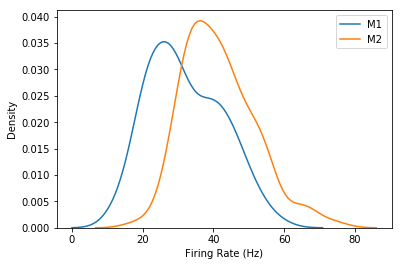

In [181]:
plt.figure()
sns.kdeplot(np.mean(M1_rates, axis=1) / p, label="M1")
sns.kdeplot(np.mean(M2_rates, axis=1) / p, label="M2")
plt.xlabel("Firing Rate (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()